In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [25]:
#format_plots()
#format_pizza_plots()

In [26]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [27]:
## update data
def remove_crl(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    #syll=(['47','48','49','50'])
    df.drop(syll,axis=1, inplace=True)
    #df.drop('b365ea6a-369f-4991-b139-15694dc1c86d',level=3, axis=0, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [28]:
# remapped to bins
mapdr_females = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 72,
       9: 90,
       }

mapdr_males = {0: 3, 
       1: 5, 
       2: 7,
       3: 9,
       4: 12,
       5: 24,
       6: 36,
       7: 52,
       8: 78,
       9: 90,
       }

In [29]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_clean_v2.parquet')
f_psd = pd.read_parquet(path)
f_psd= remove_crl(f_psd)

# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [30]:
# pseudo regression
from sklearn.cross_decomposition import PLSRegression
mdl = PLSRegression(n_components=3)
x = m_psd.filter(regex=r'\d')
y = x.index.get_level_values('psd')
mdl.fit(x, y)
print(mdl.score(x, y))

#if you want to log transform
#x = np.log(x + 1e-6) # convert to linear
x = f_psd.filter(regex=r'\d')
f_psd['psd']=mdl.predict(x)

0.9553095183555017


In [31]:
# to convert pseudo time into bins the lengh of the bins of cross-sectional data and remap:
# females
f_psd['bins'] = pd.qcut(f_psd['psd'], len(f_psd.index.get_level_values('age').unique()),labels=False)
y_psd=f_psd['bins'].to_numpy()
y_psd = [mapdr_females[item] for item in y_psd]
f_psd['remapped_bins'] = y_psd
f_psd.set_index(['remapped_bins','bins','psd'], append=True, inplace=True)

# males
m_psd['bins'] = pd.qcut(m_psd.index.get_level_values('psd'), len(m_psd.index.get_level_values('age').unique()),labels=False)
y_psd=m_psd['bins'].to_numpy()
y_psd = [mapdr_males[item] for item in y_psd]
m_psd['remapped_bins'] = y_psd
m_psd.set_index(['remapped_bins','bins'], append=True, inplace=True)

In [ ]:
f_data = f_psd.query('remapped_bins != 90').groupby(['bins']).mean()
f_labels = f_data.index.get_level_values('bins').to_numpy()

m_data = m_psd.query('remapped_bins != 90').groupby(['bins']).mean()
m_labels = m_data.index.get_level_values('bins').to_numpy()

data_umap=np.concatenate([m_data.to_numpy(),f_data.to_numpy()], axis=1).T

data_labels = f_labels

#data['sex'] = ['m'] * len(m_data) + ['f']* len(f_data)
#data.set_index('sex', append=True, inplace=True)

In [45]:
## to use the female only pseudo time

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_clean_v2.parquet')
df_age = pd.read_parquet(path)
df_age= remove_crl(df_age)

# pseudo data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_females_clean_pseudotime_v02.parquet')
df_psd = pd.read_parquet(path)
df_psd=df_psd.reset_index()
df_psd=df_psd[['uuid','pseudotime_rank']]
df_psd = pd.merge(df_age.reset_index(),df_psd,how='left',on=['uuid'])

# to convert pseudo time into bins the lengh of the bins of cross-sectional data
df_psd['bins'] = pd.qcut(df_psd['pseudotime_rank'], len(df_age.index.get_level_values(0).unique()),labels=False)
# prepare data
#y_psd=df_psd['bins'].to_numpy()
#y_psd = [mapdr[item] for item in y_psd]
#df_psd['remapped_bins'] = y_psd
#df_psd.set_index('remapped_bins', inplace=True)
df_psd.set_index('bins', inplace=True)
f_data=df_psd.filter(regex=r'\d')

f_data = f_data.groupby(['bins']).mean()

m_data = m_psd.query('remapped_bins != 90').groupby(['bins']).mean()
m_labels = m_data.index.get_level_values('bins').to_numpy()

data_umap=np.concatenate([m_data.to_numpy(),f_data.to_numpy()], axis=1).T
data_labels = m_labels

In [46]:
'''
f_data = f_psd.query('age != 90').groupby(['age']).mean()
f_labels = f_data.index.get_level_values('age').to_numpy()

m_data = m_psd.query('age != 90').groupby(['age']).mean()
m_labels = m_data.index.get_level_values('age').to_numpy()

data_umap=np.concatenate([m_data.to_numpy(),f_data.to_numpy()], axis=1).T
data_labels = f_labels
'''

"\nf_data = f_psd.query('age != 90').groupby(['age']).mean()\nf_labels = f_data.index.get_level_values('age').to_numpy()\n\nm_data = m_psd.query('age != 90').groupby(['age']).mean()\nm_labels = m_data.index.get_level_values('age').to_numpy()\n\ndata_umap=np.concatenate([m_data.to_numpy(),f_data.to_numpy()], axis=1).T\ndata_labels = f_labels\n"

In [47]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
x = np.array(range(len(data_labels)))
x = sm.add_constant(x)

mdf_temp = m_data.to_numpy()
fdf_temp = f_data.to_numpy()

In [48]:
fr2=[]
fpvalue=[]
fslop=[]
fexp=[]
mr2=[]
mpvalue=[]
mslop=[]
mexp=[]

for i in range(np.shape(mdf_temp)[1]):
    y=mdf_temp[:,i]
    #fit linear regression model
    model = sm.OLS(y, x).fit()
    #view model summary
    mr2.append(model.rsquared)
    mpvalue.append(model.f_pvalue)
    mslop.append(model.params[1])
    #fexp.append('male')
    
for i in range(np.shape(fdf_temp)[1]):
    y=fdf_temp[:,i]
    #fit linear regression model
    model = sm.OLS(y, x).fit()
    #view model summary
    fr2.append(model.rsquared)
    fpvalue.append(model.f_pvalue)
    fslop.append(model.params[1])
    #fexp.append('female')

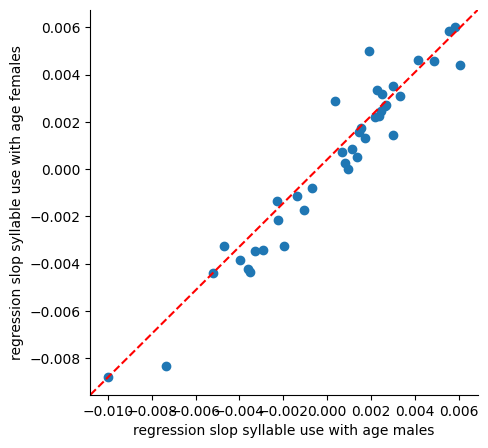

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
plt.scatter(x=mslop, y=fslop)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', c='r')
sns.despine
plt.xlabel('regression slop syllable use with age males')
plt.ylabel('regression slop syllable use with age females')
#plt.title('linear change in syllables in different sexes')
sns.despine()
#fig.savefig(data_loc +'corr_male_female_syll.pdf', bbox_inches='tight')